In [1]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import joblib

In [2]:
import sys
sys.path.append("../scripts/")
from utils import plot_confusion_matrix, print_metrics

In [3]:
# Get Data
data_path = '../data/with_features/'
train_data = pd.read_csv(f'{data_path}train.csv')
test_data = pd.read_csv(f'{data_path}test.csv')

In [4]:
train_data.head(5)

,abstract,label,num_characters,word_count,sentence_count,mean_sentence_length,burstiness,stop_words_ratio,vocabulary_size,ttr,...,flesch,noun_prop,det_prop,adj_prop,aux_prop,pron_prop,adv_prop,punct_prop,adp_prop,ppl
0,Automated seizure detection using clinical ele...,human,1368,218,9,24.222222,42.172840,0.302752,152,0.697248,...,25.69,0.223214,0.066964,0.125000,0.044643,0.040179,0.044643,0.084821,0.089286,32.600063
1,This research work aims to propose a systemati...,human,864,135,7,19.285714,17.061224,0.362963,91,0.674074,...,19.97,0.268966,0.124138,0.089655,0.041379,0.034483,0.034483,0.124138,0.117241,31.335295
2,this paper first analyses the new challenges o...,human,543,84,3,28.000000,104.666667,0.333333,46,0.547619,...,11.96,0.416667,0.119048,0.023810,0.059524,0.000000,0.047619,0.095238,0.095238,64.930687
3,Accurate network traffic identification is an ...,human,1010,160,5,32.000000,104.400000,0.331250,76,0.475000,...,7.59,0.406250,0.075000,0.068750,0.050000,0.018750,0.000000,0.075000,0.093750,19.533455
4,The combinatorial explosion problem is a great...,human,1591,256,10,25.600000,76.640000,0.378906,130,0.507812,...,22.75,0.218750,0.121094,0.121094,0.062500,0.035156,0.042969,0.097656,0.085938,35.863876


In [5]:
train_data.columns

Index(['abstract', 'label', 'num_characters', 'word_count', 'sentence_count',
       'mean_sentence_length', 'burstiness', 'stop_words_ratio',
       'vocabulary_size', 'ttr', 'preprocessed_abstract', 'tfidf_method',
       'tfidf_approach', 'tfidf_proposed', 'tfidf_paper', 'tfidf_study',
       'tfidf_analysis', 'tfidf_using', 'tfidf_application', 'tfidf_potential',
       'tfidf_performance', 'tfidf_network', 'tfidf_algorithm',
       'tfidf_feature', 'tfidf_learning', 'tfidf_data', 'tfidf_model',
       'tfidf_control', 'tfidf_information', 'tfidf_accuracy',
       'tfidf_technique', 'flesch', 'noun_prop', 'det_prop', 'adj_prop',
       'aux_prop', 'pron_prop', 'adv_prop', 'punct_prop', 'adp_prop', 'ppl'],
      dtype='object')

## `Human vs Generation`

In [6]:
# feature matrix X and target y
feature_cols = ['num_characters', 'word_count', 'sentence_count',
                'mean_sentence_length', 'burstiness', 'stop_words_ratio',
                'vocabulary_size', 'ttr', 'tfidf_method', 'tfidf_approach',
                'tfidf_proposed', 'tfidf_paper', 'tfidf_study', 'tfidf_analysis',
                'tfidf_using', 'tfidf_application', 'tfidf_potential',
                'tfidf_performance', 'tfidf_network', 'tfidf_algorithm',
                'tfidf_feature', 'tfidf_learning', 'tfidf_data', 'tfidf_model',
                'tfidf_control', 'tfidf_information', 'tfidf_accuracy',
                'tfidf_technique', 'flesch', 'noun_prop', 'det_prop', 'adj_prop',
                'aux_prop', 'pron_prop', 'adv_prop', 'punct_prop', 'adp_prop', 'ppl']

# Keep only human and generation labels
Z_train = train_data[train_data['label'].isin(['human', 'generation'])].copy()
Z_test = test_data[test_data['label'].isin(['human', 'generation'])].copy()

Z_train['label'] = Z_train['label'].map({'human': 0, 'generation': 1})
Z_test['label'] = Z_test['label'].map({'human': 0, 'generation': 1})

X_train = Z_train[feature_cols]
y_train = Z_train['label']

X_test = Z_test[feature_cols]
y_test = Z_test['label']

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (24632, 38)
y_train shape: (24632,)
X_test shape: (6158, 38)
y_test shape: (6158,)


In [7]:
# Label count
print(y_train.value_counts())

label
0    12316
1    12316
Name: count, dtype: int64


In [8]:
# Pipeline: scaling + logistic regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(solver='liblinear', max_iter=1000, random_state=42, verbose=0))
])

In [9]:
# Hyperparameter grid
param_grid = {
    'clf__C': [700, 720, 740, 760, 780, 800, 820, 840, 860, 880, 900],
    'clf__penalty': ['l1', 'l2']
}

In [10]:
# Grid search with 5‑fold CV, optimizing for ROC AUC
grid = GridSearchCV(
    pipeline, param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1,
)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 22 candidates, totalling 110 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=42,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'clf__C': [700, 720, 740, 760, 780, 800, 820, 840, 860,
                                    880, 900],
                         'clf__penalty': ['l1', 'l2']},
             scoring='roc_auc', verbose=1)

In [11]:
print("Best params:", grid.best_params_)
print("Best score:", grid.best_score_)

Best params: {'clf__C': 700, 'clf__penalty': 'l2'}
Best score: 0.9954316836622308


In [12]:
# Evaluate on test set
y_pred = grid.predict(X_test)
y_proba = grid.predict_proba(X_test)[:, 1]

In [13]:
# print Accuracy and AUC
print_metrics(y_test, y_pred, y_proba)

Accuracy: 0.9719
AUC: 0.9955


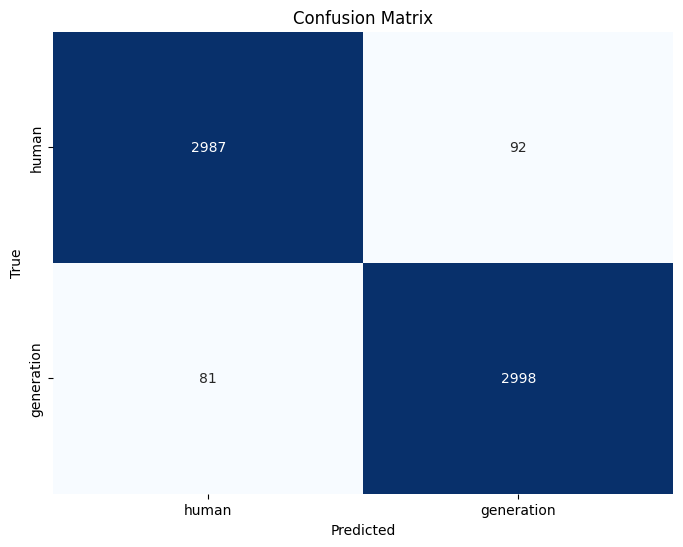

In [14]:
# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred, labels=['human', 'generation'])

In [15]:
# Save the model
joblib.dump(grid, '../models/human_vs_generation/logistic_regression_model.pkl')

['../models/human_vs_generation/logistic_regression_model.pkl']

## `Human vs Polish`

In [16]:
# feature matrix X and target y
feature_cols = ['num_characters', 'word_count', 'sentence_count',
                'mean_sentence_length', 'burstiness', 'stop_words_ratio',
                'vocabulary_size', 'ttr', 'tfidf_method', 'tfidf_approach',
                'tfidf_proposed', 'tfidf_paper', 'tfidf_study', 'tfidf_analysis',
                'tfidf_using', 'tfidf_application', 'tfidf_potential',
                'tfidf_performance', 'tfidf_network', 'tfidf_algorithm',
                'tfidf_feature', 'tfidf_learning', 'tfidf_data', 'tfidf_model',
                'tfidf_control', 'tfidf_information', 'tfidf_accuracy',
                'tfidf_technique', 'flesch', 'noun_prop', 'det_prop', 'adj_prop',
                'aux_prop', 'pron_prop', 'adv_prop', 'punct_prop', 'adp_prop', 'ppl']


# Keep only human and polish labels
Z_train = train_data[train_data['label'].isin(['human', 'polish'])].copy()
Z_test = test_data[test_data['label'].isin(['human', 'polish'])].copy()

Z_train['label'] = Z_train['label'].map({'human': 0, 'polish': 1})
Z_test['label'] = Z_test['label'].map({'human': 0, 'polish': 1})

X_train = Z_train[feature_cols]
y_train = Z_train['label']

X_test = Z_test[feature_cols]
y_test = Z_test['label']

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (24632, 38)
y_train shape: (24632,)
X_test shape: (6158, 38)
y_test shape: (6158,)


In [17]:
# Label count
print(y_train.value_counts())

label
0    12316
1    12316
Name: count, dtype: int64


In [18]:
# Pipeline: scaling + logistic regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(solver='liblinear', max_iter=1000, random_state=42, verbose=0))
])

In [19]:
# Hyperparameter grid
param_grid = {
    'clf__C': [0.1, 0.2, 0.3, 0.4, 0.5],
    'clf__penalty': ['l1', 'l2', 'elasticnet'],
    'clf__l1_ratio': [0.005, 0.01, 0.015, 0.02, 0.025],
}

In [20]:
# Grid search with 5‑fold CV, optimizing for ROC AUC
grid = GridSearchCV(
    pipeline, param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1,
)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 75 candidates, totalling 375 fits


/users/eleves-a/2021/abasse.dabere/Desktop/ChatGPT-Generated-Abstracts-Detection/.venv/lib64/python3.9/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/users/eleves-a/2021/abasse.dabere/Desktop/ChatGPT-Generated-Abstracts-Detection/.venv/lib64/python3.9/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/users/eleves-a/2021/abasse.dabere/Desktop/ChatGPT-Generated-Abstracts-Detection/.venv/lib64/python3.9/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/users/eleves-a/2021/abasse.dabere/Desktop/ChatGPT-Generated-Abstracts-Detection/.venv/lib64/python3.9/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=42,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.1, 0.2, 0.3, 0.4, 0.5],
                         'clf__l1_ratio': [0.005, 0.01, 0.015, 0.02, 0.025],
                         'clf__penalty': ['l1', 'l2', 'elasticnet']},
             scoring='roc_auc', verbose=1)

In [21]:
print("Best params:", grid.best_params_)
print("Best score:", grid.best_score_)

Best params: {'clf__C': 0.2, 'clf__l1_ratio': 0.005, 'clf__penalty': 'l1'}
Best score: 0.8519126005332704


In [22]:
# Evaluate on test set
y_pred = grid.predict(X_test)
y_proba = grid.predict_proba(X_test)[:, 1]

In [23]:
# print Accuracy and AUC
print_metrics(y_test, y_pred, y_proba)

Accuracy: 0.7848
AUC: 0.8584


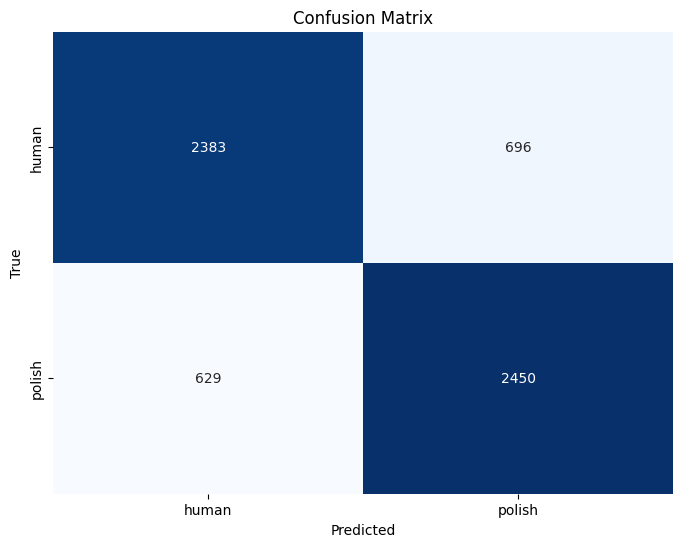

In [24]:
# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred, labels=['human', 'polish'])

In [25]:
# Save the model
joblib.dump(grid, '../models/human_vs_polish/logistic_regression_model.pkl')

['../models/human_vs_polish/logistic_regression_model.pkl']

## `Human vs Mix`

In [26]:
# feature matrix X and target y
feature_cols = ['num_characters', 'word_count', 'sentence_count',
                'mean_sentence_length', 'burstiness', 'stop_words_ratio',
                'vocabulary_size', 'ttr', 'tfidf_method', 'tfidf_approach',
                'tfidf_proposed', 'tfidf_paper', 'tfidf_study', 'tfidf_analysis',
                'tfidf_using', 'tfidf_application', 'tfidf_potential',
                'tfidf_performance', 'tfidf_network', 'tfidf_algorithm',
                'tfidf_feature', 'tfidf_learning', 'tfidf_data', 'tfidf_model',
                'tfidf_control', 'tfidf_information', 'tfidf_accuracy',
                'tfidf_technique', 'flesch', 'noun_prop', 'det_prop', 'adj_prop',
                'aux_prop', 'pron_prop', 'adv_prop', 'punct_prop', 'adp_prop', 'ppl']


# Keep only human and mix labels
Z_train = train_data[train_data['label'].isin(['human', 'mix'])].copy()
Z_test = test_data[test_data['label'].isin(['human', 'mix'])].copy()

Z_train['label'] = Z_train['label'].map({'human': 0, 'mix': 1})
Z_test['label'] = Z_test['label'].map({'human': 0, 'mix': 1})

# Split the data into human and mix
train_h = Z_train[Z_train['label'] == 0]
train_f = Z_train[Z_train['label'] == 1]
test_h  = Z_test[Z_test['label']  == 0]
test_f  = Z_test[Z_test['label']  == 1]

# Number of samples in the minority class
n_train = min(len(train_h), len(train_f))
n_test  = min(len(test_h),  len(test_f))

# Undersample the majority class
train_h_down = train_h.sample(n_train, replace=False, random_state=42)
train_f_down = train_f.sample(n_train, replace=False, random_state=42)
test_h_down  = test_h.sample(n_test,  replace=False, random_state=42)
test_f_down  = test_f.sample(n_test,  replace=False, random_state=42)

# Concatenate the undersampled data
Z_train = pd.concat([train_h_down, train_f_down], axis=0)
Z_test  = pd.concat([test_h_down, test_f_down], axis=0)

# feature matrix X and target y
X_train = Z_train[feature_cols]
y_train = Z_train['label']

X_test = Z_test[feature_cols]
y_test = Z_test['label']

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (7222, 38)
y_train shape: (7222,)
X_test shape: (1806, 38)
y_test shape: (1806,)


In [27]:
# Label count
print(y_train.value_counts()), print(y_test.value_counts())

label
0    3611
1    3611
Name: count, dtype: int64
label
0    903
1    903
Name: count, dtype: int64


(None, None)

In [28]:
# Pipeline: scaling + logistic regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(solver='liblinear', max_iter=1000, random_state=42, verbose=0))
])

In [29]:
# Hyperparameter grid
param_grid = {
    'clf__C': [0.1, 0.2, 0.3, 0.4, 0.5],
    'clf__penalty': ['l1', 'l2', 'elasticnet'],
    'clf__l1_ratio': [0.005, 0.01, 0.015, 0.02, 0.025],
}

In [30]:
# Grid search with 5‑fold CV, optimizing for ROC AUC
grid = GridSearchCV(
    pipeline, param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1,
)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 75 candidates, totalling 375 fits


/users/eleves-a/2021/abasse.dabere/Desktop/ChatGPT-Generated-Abstracts-Detection/.venv/lib64/python3.9/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/users/eleves-a/2021/abasse.dabere/Desktop/ChatGPT-Generated-Abstracts-Detection/.venv/lib64/python3.9/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/users/eleves-a/2021/abasse.dabere/Desktop/ChatGPT-Generated-Abstracts-Detection/.venv/lib64/python3.9/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/users/eleves-a/2021/abasse.dabere/Desktop/ChatGPT-Generated-Abstracts-Detection/.venv/lib64/python3.9/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=42,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.1, 0.2, 0.3, 0.4, 0.5],
                         'clf__l1_ratio': [0.005, 0.01, 0.015, 0.02, 0.025],
                         'clf__penalty': ['l1', 'l2', 'elasticnet']},
             scoring='roc_auc', verbose=1)

In [31]:
print("Best params:", grid.best_params_)
print("Best score:", grid.best_score_)

Best params: {'clf__C': 0.4, 'clf__l1_ratio': 0.005, 'clf__penalty': 'l2'}
Best score: 0.7005607117070423


In [32]:
# Evaluate on test set
y_pred = grid.predict(X_test)
y_proba = grid.predict_proba(X_test)[:, 1]

In [33]:
# print Accuracy and AUC
print_metrics(y_test, y_pred, y_proba)

Accuracy: 0.6573
AUC: 0.7131


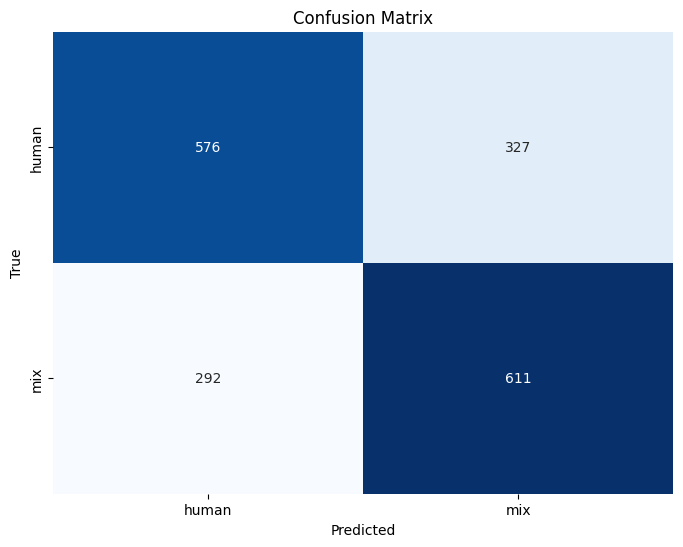

In [34]:
# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred, labels=['human', 'mix'])

In [35]:
# Save the model
joblib.dump(grid.best_estimator_, '../models/human_vs_mix/logistic_regression_model.pkl')

['../models/human_vs_mix/logistic_regression_model.pkl']